# LightBGM 示範用

In [13]:
!pip install --quiet lightgbm

In [14]:
# iris_lightgbm_native.py
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

## 0. 讀取資料

In [45]:
data = pd.read_csv("./0_iris.csv").dropna()

### 0.1 模組化(重構成為函數，有詳細輸入輸出以及註解

In [37]:
def load_and_preprocess_data(data_path: str) -> pd.DataFrame:
    """Loads and preprocesses the raw data."""
    data = pd.read_csv(data_path)
    data.dropna(inplace=True)
    return data

### 0.2 封裝成 component 元件

In [41]:
from kfp.dsl import component, Output, Dataset
import pandas as pd, pyarrow.parquet as pq, pyarrow as pa

@component(base_image="python:3.9", packages_to_install=["pandas==2.0.3", "pyarrow==15.0.2"])
def load_data(data_path: str, cleaned: Output[Dataset]):
    import pandas as pd, pyarrow.parquet as pq, pyarrow as pa
    df = pd.read_csv(data_path).dropna()
    pq.write_table(pa.Table.from_pandas(df), cleaned.path)

## 1. 讀取資料並清理

In [46]:
# LightGBM 原生 Dataset 需要數字 label
label_encoded = data["Species"].astype("category").cat.codes
features = data[["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"]]

## 2. 切分訓練 / 測試集

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    features, label_encoded,
    test_size=0.2,
    stratify=label_encoded,
    random_state=42
)

## 3. 建立 LightGBM Dataset

In [48]:
train_ds = lgb.Dataset(X_train, label=y_train)
valid_ds = lgb.Dataset(X_test, label=y_test, reference=train_ds)

## 4. 設定訓練參數

In [49]:
params = {
    "objective": "multiclass",
    "num_class": 3,                # Iris 有 3 個類別
    "metric": "multi_logloss",     # 也可加入 "multi_error"
    "learning_rate": 0.05,
    "num_leaves": 31,              # 預設 31，影響模型複雜度
    "feature_fraction": 0.9,       # 每棵樹隨機選 90% 特徵
    "bagging_fraction": 0.8,       # 每棵樹隨機選 80% 樣本
    "bagging_freq": 1,             # 每次建樹都 bagging
    "verbosity": -1                # 關閉額外訊息
}

## 5. 開始訓練

In [50]:
print("Training...")
gbm = lgb.train(
    params,
    train_ds,
    num_boost_round=500,           # 最多 500 棵樹
    valid_sets=[valid_ds],
    valid_names=["valid"],
    # verbose_eval=20,                # 每 20 棵樹列印一次 loss
    # early_stopping_rounds=50,      # 50 棵樹沒進步就停
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=20)
    ]
)

Training...
Training until validation scores don't improve for 50 rounds
[20]	valid's multi_logloss: 0.357382
[40]	valid's multi_logloss: 0.233752
[60]	valid's multi_logloss: 0.22769
[80]	valid's multi_logloss: 0.270272
[100]	valid's multi_logloss: 0.322489
Early stopping, best iteration is:
[52]	valid's multi_logloss: 0.220241


## 6. 預測與評估

In [51]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_pred_label = np.argmax(y_pred, axis=1)

print("\n=== Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred_label))
print(classification_report(y_test, y_pred_label))


=== Evaluation ===
Accuracy : 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## 7. 顯示特徵重要度

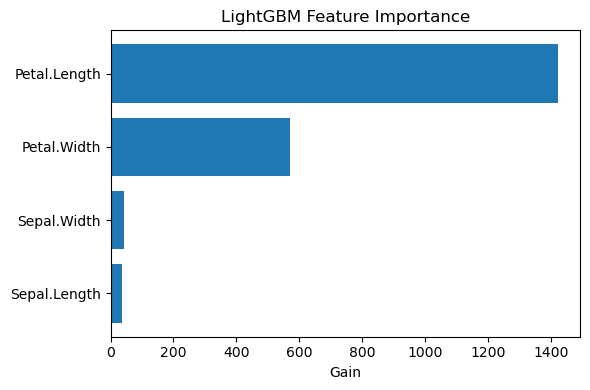

In [52]:
import matplotlib.pyplot as plt

importance = gbm.feature_importance(importance_type="gain")
indices = np.argsort(importance)[::-1]
feature_names = features.columns[indices]

plt.figure(figsize=(6, 4))
plt.barh(feature_names, importance[indices])
plt.xlabel("Gain")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()